<a href="https://www.kaggle.com/code/guidosalimbeni/gan-3d-morandi-images?scriptVersionId=125289922" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

* **GAN** (Generative Adversarial Network) is a deep learning architecture that can generate synthetic data that resembles real data. The idea behind GANs is to have two neural networks that compete with each other: a generator and a discriminator. The generator tries to create synthetic data that can fool the discriminator, while the discriminator tries to distinguish between the synthetic data and the real data. Through this adversarial training process, the generator becomes better at generating realistic data, while the discriminator becomes better at distinguishing between the real and fake data.

* **In this notebook**, we will be using GANs to generate images of compositions inspired by the work of Giorgio Morandi. Giorgio Morandi was an Italian painter known for his still-life compositions, particularly his use of simple shapes and muted colors. We will use a dataset of Morandi-inspired compositions and train a GAN to generate new, synthetic compositions that resemble those in the dataset. The goal is to create a generator that can produce novel and compelling compositions that capture the essence of Morandi's style.

* **TODO**
1. Consider using TensorFlow functions for image processing instead of using OpenCV, PIL, and NumPy. This will allow you to better leverage GPU acceleration and make the code more consistent.
2. In the custom_loss function, you are using Python loops to calculate the golden rule and similarity scores. Instead of using Python loops, it's more efficient to vectorize the operations with TensorFlow functions. This will enable parallel execution on GPUs and TPUs, leading to faster training times.
3. Currently, the custom loss function is only applied to the generator. If you want to make the discriminator consider real images that follow the golden rule and similarity constraint as well, you can modify the discriminator's loss function. One option is to modify the wrapped_custom_loss function to take into account the golden rule and similarity constraints, then apply this modified loss function when compiling the discriminator model.
4. The current custom loss function calculates the normalized black pixel difference, golden rule score, and similarity score, but it's unclear whether these are balanced in terms of their contributions to the total loss. You may need to experiment with different weightings for these terms to achieve the desired results.
5. The golden rule and similarity constraints are only applied during generator training. If you want these constraints to also apply during discriminator training, you can modify the train_gan function accordingly, by including the constraints when training the discriminator.

In [26]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from PIL import ImageOps
import cv2
from skimage.metrics import structural_similarity as ssim
import logging

tf.get_logger().setLevel(logging.INFO)


img_folder = "/kaggle/input/compositions-of-3d-models/"
img_height, img_width = 64, 64
latent_dim = 100
epochs = 10000
batch_size = 32


def calculate_golden_rule_score(image_tensor):
    
    image = image_tensor.numpy()

    # Ensure the image has the correct depth (8-bit unsigned integer)
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # Detect keypoints using SIFT
    sift = cv2.SIFT_create()
    keypoints = sift.detect(image, None)

    # Find the most important point
    most_important_point = max(keypoints, key=lambda x: x.response).pt

    # Find the center of the image
    center_x, center_y = image.shape[1] / 2, image.shape[0] / 2

    # Normalize the coordinates of the most important point relative to the center
    norm_x, norm_y = most_important_point[0] - center_x, most_important_point[1] - center_y

    # Convert the normalized Cartesian coordinates to polar coordinates
    r, theta = np.sqrt(norm_x**2 + norm_y**2), np.arctan2(norm_y, norm_x)

    # Calculate the angle difference between the most important point and the closest point on the golden spiral
    golden_ratio = (1 + np.sqrt(5)) / 2
    b = 2 * np.pi / np.log(golden_ratio)
    theta_golden = theta % b
    angle_diff = min(abs(theta - theta_golden), abs(theta - (theta_golden + b)))

    # Normalize the angle difference to a range of [0, 1]
    max_angle_diff = np.pi
    normalized_angle_diff = angle_diff / max_angle_diff

    # Calculate the score
    score = 1 - normalized_angle_diff

    return score

image_path1 = "/kaggle/input/single-image2/cross.png"
image_np1 = cv2.imread(image_path1)

def image_similarity_score(image_np1, image_np2):
    # Ensure both images have the same shape
    image = image_np2.numpy()
    
    if image_np1.shape != image.shape:
        raise ValueError("Images must have the same shape")

    # Convert images to grayscale if they are not
    if len(image_np1.shape) == 3:
        image_np1 = cv2.cvtColor(image_np1, cv2.COLOR_BGR2GRAY)

    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute SSIM between the two images
    similarity = ssim(image_np1, image)

    # SSIM returns a value in the range of [-1, 1]. Normalize it to [0, 1].
    normalized_similarity = (similarity + 1) / 2

    return normalized_similarity


def custom_loss(y_true, y_pred,  real_imgs=None, gen_imgs=None, black_pixel_threshold=0.1, constraint_weight=0.02):
    mse = tf.keras.losses.MeanSquaredError()
    base_loss = mse(y_true, y_pred)
    if real_imgs is None or gen_imgs is None:
        return base_loss

    # Calculate the number of black pixels on both sides of the generated images
    left_side = gen_imgs[:, :, :gen_imgs.shape[2] // 2]
    right_side = gen_imgs[:, :, gen_imgs.shape[2] // 2:]
    black_pixels_left = tf.reduce_sum(tf.cast(left_side <= black_pixel_threshold, tf.float32))
    black_pixels_right = tf.reduce_sum(tf.cast(right_side <= black_pixel_threshold, tf.float32))

    # Calculate the absolute difference between the black pixel counts
    black_pixels_diff = tf.abs(black_pixels_left - black_pixels_right)
    
    # Calculate the maximum possible difference between black pixels
    max_diff = gen_imgs.shape[1] * gen_imgs.shape[2] // 2

    # Normalize the black pixels difference to a range of [0, 1]
    normalized_black_pixels_diff = black_pixels_diff / max_diff
    
    # calculate the golden rule score
    scores = []
    similarity_scores = []
    for image in gen_imgs:
        try:
            scores.append(calculate_golden_rule_score(image))
            similarity_scores.append (image_similarity_score(image_np1, image))
        except:
            scores.append (0.5)
            similarity_scores.append (0.5)
            
    golden_score = sum(scores) / len(scores)
    sim_score = sum(similarity_scores) / len(similarity_scores)

    # Add the difference as a penalty to the base loss, with a weight of 10%
    total_loss = base_loss + constraint_weight * normalized_black_pixels_diff + (1 - golden_score) #+ (1-sim_score)

    return total_loss

def wrapped_custom_loss(y_true, y_pred):
    return custom_loss(y_true, y_pred)

# GAN components
def build_generator(latent_dim, img_shape):
    input_noise = Input(shape=(latent_dim,))
    x = Dense(128 * 16 * 16, activation="relu")(input_noise)
    x = Reshape((16, 16, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    output_img = Conv2DTranspose(3, kernel_size=3, strides=1, padding="same", activation="tanh")(x)
    return Model(input_noise, output_img)


def build_discriminator(img_shape):
    input_img = Input(shape=img_shape)
    x = Conv2D(32, kernel_size=3, strides=2, padding="same")(input_img)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    output = Dense(1, activation='sigmoid')(x)
    return Model(input_img, output)

# Loading dataset
def load_data(img_folder, img_height, img_width):
    images = []
    for img_name in os.listdir(img_folder):
#         if img_name.endswith('.png') and (img_name.startswith('08') or img_name.startswith('09')or img_name.startswith('07')):
        if img_name.endswith('.png'):
            img = load_img(os.path.join(img_folder, img_name), target_size=(img_height, img_width))
            img = img_to_array(img)
            img = (img - 127.5) / 127.5
            images.append(img)
    return np.array(images)


generator_optimizer = Adam(0.0002, 0.5)


def train_gan(generator, discriminator, combined, epochs, batch_size, latent_dim, dataset):
    
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, dataset.shape[0], batch_size)
        real_imgs = dataset[idx]
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)
        
        
        d_loss_real = discriminator.train_on_batch(real_imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        real_imgs = dataset[np.random.randint(0, dataset.shape[0], batch_size)]

        with tf.GradientTape() as tape:
            gen_imgs = generator(noise, training=True)
            valid = discriminator(gen_imgs)

            g_loss = custom_loss(real, valid, real_imgs, gen_imgs)
            

        grads = tape.gradient(g_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    
        if epoch%100 == 0:
            print("Epoch %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))


# Load dataset
dataset = load_data(img_folder, img_height, img_width)

# Build and compile models
generator = build_generator(latent_dim, (img_height, img_width, 3))
discriminator = build_discriminator((img_height, img_width, 3))
discriminator.compile(loss=wrapped_custom_loss, optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])


noise_input = Input(shape=(latent_dim,))
img = generator(noise_input)
discriminator.trainable = False
validity = discriminator(img)
combined = Model(noise_input, validity)
combined.compile(loss=wrapped_custom_loss, optimizer=Adam(0.0002, 0.5))

# Train GAN
train_gan(generator, discriminator, combined, epochs, batch_size, latent_dim, dataset)


1/1 [==============================] - 0s 126ms/step


2023-04-10 15:59:26.169176: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_19/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 0 [D loss: 0.266216, acc.: 12.50%] [G loss: 2.583769]
1/1 [==============================] - 0s 28ms/step
Epoch 100 [D loss: 0.159650, acc.: 81.25%] [G loss: 2.325723]
1/1 [==============================] - 0s 23ms/step
Epoch 200 [D loss: 0.184053, acc.: 67.19%] [G loss: 2.365644]
1/1 [==============================] - 0s 22ms/step
Epoch 300 [D loss: 0.218107, acc.: 59.38%] [G loss: 2.997386]
1/1 [==============================] - 0s 20ms/step
Epoch 400 [D loss: 0.179718, acc.: 76.56%] [G loss: 3.058079]
1/1 [==============================] - 0s 20ms/step
Epoch 500 [D loss: 0.228313, acc.: 60.94%] [G loss: 3.011125]
1/1 [==============================] - 0s 20ms/step
Epoch 600 [D loss: 0.203937, acc.: 62.50%] [G loss: 3.221001]
1/1 [==============================] - 0s 19ms/step
Epoch 700 [D loss: 0.225833, acc.: 59.38%] [G loss: 3.020282]
1/1 [==============================] - 0s 20ms/step
Epoch 800 [D loss: 0.243200, acc.: 50.00%] [G loss: 3.133929]
1/1 [=======================

In [27]:


# Save models
generator.save("generator_model.h5")
discriminator.save("discriminator_model.h5")
print("Models saved as generator_model.h5 and discriminator_model.h5")


Models saved as generator_model.h5 and discriminator_model.h5


1/1 [==============================] - 0s 28ms/step


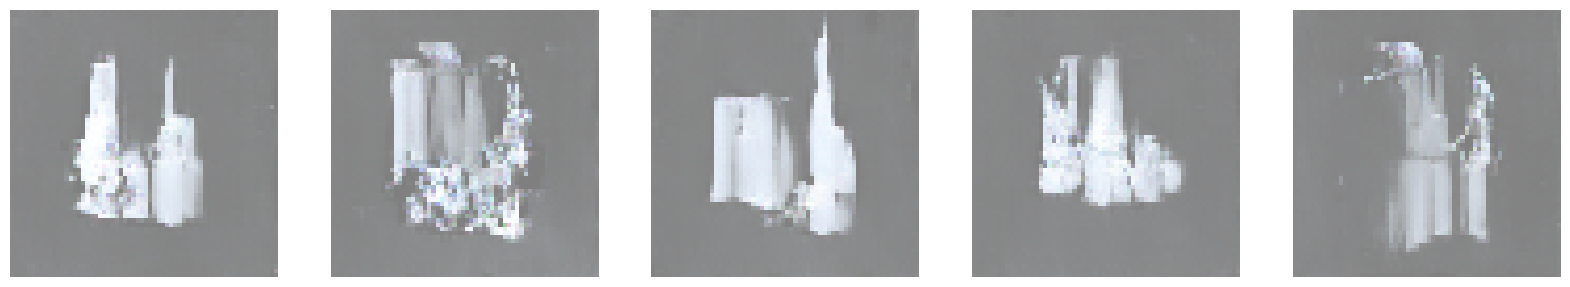

In [60]:
# Generate new images
def generate_images(generator, latent_dim, num_images):
    noise = np.random.normal(0, 1, (num_images, latent_dim))
    generated_imgs = generator.predict(noise)
    generated_imgs = 0.5 * generated_imgs + 0.5
    return generated_imgs
# Generate new images
num_images = 5
generated_imgs = generate_images(generator, latent_dim, num_images)


# from tensorflow.keras.models import load_model

# # Load the models
# generator = load_model("generator_model.h5", compile=False)
# discriminator = load_model("discriminator_model.h5", custom_objects={"custom_loss": custom_loss})


# Display generated images
fig, axes = plt.subplots(1, num_images, figsize=(20, 20))

for i, img in enumerate(generated_imgs):
    axes[i].imshow((img * 127.5 + 127.5).astype(np.uint8))
    axes[i].axis('off')

plt.show()

In [29]:
# Save generated images
for i, img in enumerate(generated_imgs):
    img_name = f"generated_{i + 1}.png"
    array_to_img(img).save(img_name)
    print(f"Generated image saved as {img_name}")

Generated image saved as generated_1.png
Generated image saved as generated_2.png
Generated image saved as generated_3.png
Generated image saved as generated_4.png
Generated image saved as generated_5.png
